# RCT statistical analysis
<p>This workbook contains R code for analysing a randomised controlled trial (RCT) in which participants with type 2 diabetes were randomized to one of two groups: "Control" (placebo) or "Treatment" (a glucose-lowering drug). In both groups, blood glucose ("BloodGlucose") was measured before and after 12 weeks.
<p>The data is fictional and was simulated.
<p>The null hypothesis was that there is no difference between the effect of treatment and the effect of control on blood glucose. The alternate hypothesis was that treatment improves (lowers) blood glucose more than control.
<p>The following statistical approaches were used to compare between group changes in blood glucose:
<ul>
<li>Two-way repeated-measures ANOVA.
<li>Linear mixed modeling.
<li>Bayesian modeling.
<ul>

# install packages

In [1]:
# check version of R
R.version.string

[1] "R version 4.5.0 (2025-04-11)"

In [2]:
# Install packages that are not already installed
if (!requireNamespace("tidyverse", quietly = TRUE)) {
  install.packages("tidyverse")
}
if (!requireNamespace("dabestr", quietly = TRUE)) {
  install.packages("dabestr")
}
library(tidyverse)
library(dabestr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘dabestr’


The following object is masked from ‘package:base’:

    load




# load data

In [3]:
# Use a power calculation to determine the sample size for a randomized controlled trial in which a two-way ANOVA will be used to assess the change in BloodGlucose in adults with type 2 diabetes before and after taking a diabetes drug or placebo for 12 weeks. So, the ANOVA will have main effect of time (pre, post), main effect of group (drug, placebo), and their interactions. The expected effect size for this change is Cohen's D = 0.4. Assume an equal number of participants per group. Include consideration for an attrition rate of 10%.

# Install necessary package if not already installed
if(!require(pwr)){install.packages("pwr")}
library(pwr)

# Define parameters
effect_size <- 0.4  # Cohen's D
alpha <- 0.05       # Significance level
power <- 0.80       # Desired power
attrition_rate <- 0.10 # Attrition rate

# Calculate initial sample size per group (without considering attrition)
# Note: For two-way ANOVA with interaction, we use pwr.anova.test.
# We approximate the effect size for the interaction term.
# This is a simplification and a more nuanced approach may be necessary.

sample_size_per_group <- pwr.anova.test(k=2, # Number of groups
                                        f=effect_size, # Effect size
                                        sig.level = alpha,
                                        power = power)$n

# Adjust for attrition
adjusted_sample_size_per_group <- ceiling(sample_size_per_group / (1 - attrition_rate))

# Print the results
cat("Initial Sample Size per Group (without attrition):", sample_size_per_group, "\n")
cat("Adjusted Sample Size per Group (with attrition):", adjusted_sample_size_per_group, "\n")
cat("Total Sample Size (with attrition):", adjusted_sample_size_per_group * 2, "\n")

Loading required package: pwr



Initial Sample Size per Group (without attrition): 25.52458 
Adjusted Sample Size per Group (with attrition): 29 
Total Sample Size (with attrition): 58 


In [4]:
# Simulate data in a long format dataframe (df) for a randomized controlled trial of people ('ID') randomized to one of two groups: 'Control' and 'Treatment'. 'BloodGlucose' should be measured at two time points ('Time': Baseline and Week12). There should be 58 people in total, 29 in Control and 29 in Treatment. Each participant should have one 'BloodGlucose' measurement at Baseline and one at Week12. BloodGlucose values should range from 7 to 14 and should increase by approximately 0.5 in the Control group and decrease by approximately 1 in the Treatment group. There should be approximately a 10% attrition rate, i.e. Week12 BloodGlucose values should be missing for approximately 10% of the observations.

# Set seed for reproducibility
set.seed(42)

# Total number of participants and per group
n_total <- 58
n_per_group <- n_total / 2  # 56 per group

# Create participant IDs and assign groups
IDs <- 1:n_total
Group <- c(rep("Control", n_per_group), rep("Treatment", n_per_group))
df_participants <- data.frame(ID = IDs, Group = Group)

# Simulate baseline BloodGlucose uniformly between 7 and 14
baseline_glucose <- runif(n_total, min = 7, max = 14)

# Create a dataframe for Baseline measurements
df_baseline <- df_participants %>%
  mutate(Time = "Baseline",
         BloodGlucose = baseline_glucose)

# For Week12, simulate changes by group:
#  - Control: increase by ~0.5 plus noise
#  - Treatment: decrease by ~1 plus noise
noise_control <- rnorm(n_per_group, mean = 0, sd = 0.2)
noise_treatment <- rnorm(n_per_group, mean = 0, sd = 0.2)

week12_glucose_control <- baseline_glucose[1:n_per_group] + 0.5 + noise_control
week12_glucose_treatment <- baseline_glucose[(n_per_group+1):n_total] - 1 + noise_treatment

# Ensure values are within the range [7, 14]
week12_glucose_control <- pmax(pmin(week12_glucose_control, 14), 7)
week12_glucose_treatment <- pmax(pmin(week12_glucose_treatment, 14), 7)

# Combine Week12 glucose values
week12_glucose <- c(week12_glucose_control, week12_glucose_treatment)

# Introduce ~10% attrition for Week12 measurements (set approximately 10% to NA)
attrition_mask <- runif(n_total) < 0.10
week12_glucose[attrition_mask] <- NA

# Create a dataframe for Week12 measurements
df_week12 <- df_participants %>%
  mutate(Time = "Week12",
         BloodGlucose = week12_glucose)

# Combine Baseline and Week12 data into a long-format dataframe
df <- bind_rows(df_baseline, df_week12) %>%
  arrange(ID, Time)

print(head(df))  # view first few rows

  ID   Group     Time BloodGlucose
1  1 Control Baseline    13.403642
2  1 Control   Week12    13.775643
3  2 Control Baseline    13.559528
4  2 Control   Week12    14.000000
5  3 Control Baseline     9.002977
6  3 Control   Week12     9.643944


# Exploratory data analysis

In [5]:
# Examine the df
str(df)

'data.frame':	116 obs. of  4 variables:
 $ ID          : int  1 1 2 2 3 3 4 4 5 5 ...
 $ Group       : chr  "Control" "Control" "Control" "Control" ...
 $ Time        : chr  "Baseline" "Week12" "Baseline" "Week12" ...
 $ BloodGlucose: num  13.4 13.8 13.6 14 9 ...


In [6]:
# Examine the df
summary(df)

       ID          Group               Time            BloodGlucose   
 Min.   : 1.0   Length:116         Length:116         Min.   : 7.000  
 1st Qu.:15.0   Class :character   Class :character   1st Qu.: 9.404  
 Median :29.5   Mode  :character   Mode  :character   Median :11.227  
 Mean   :29.5                                         Mean   :10.958  
 3rd Qu.:44.0                                         3rd Qu.:12.711  
 Max.   :58.0                                         Max.   :14.000  
                                                      NA's   :4       

In [7]:
# Examine the df
df

ID,Group,Time,BloodGlucose
<int>,<chr>,<chr>,<dbl>
1,Control,Baseline,13.403642
1,Control,Week12,13.775643
2,Control,Baseline,13.559528
2,Control,Week12,14.000000
3,Control,Baseline,9.002977
3,Control,Week12,9.643944
4,Control,Baseline,12.813133
4,Control,Week12,13.520154
5,Control,Baseline,11.492219


## Identify and deal with missing values

In [8]:
# Quantify the number of missing values
print(colSums(is.na(df)))

          ID        Group         Time BloodGlucose 
           0            0            0            4 


In [9]:
# Drop rows with missing values in the 'BloodGlucose' column
df_dropNaN <- df %>%
  drop_na(BloodGlucose)

# Print the number of missing values in the original and complete dataframes
cat("Number of missing values in the original dataframe:", sum(is.na(df$BloodGlucose)), "\n")
cat("Number of missing values in the new dataframe:", sum(is.na(df_dropNaN$BloodGlucose)), "\n")

Number of missing values in the original dataframe: 4 
Number of missing values in the new dataframe: 0 


## Identify outliers

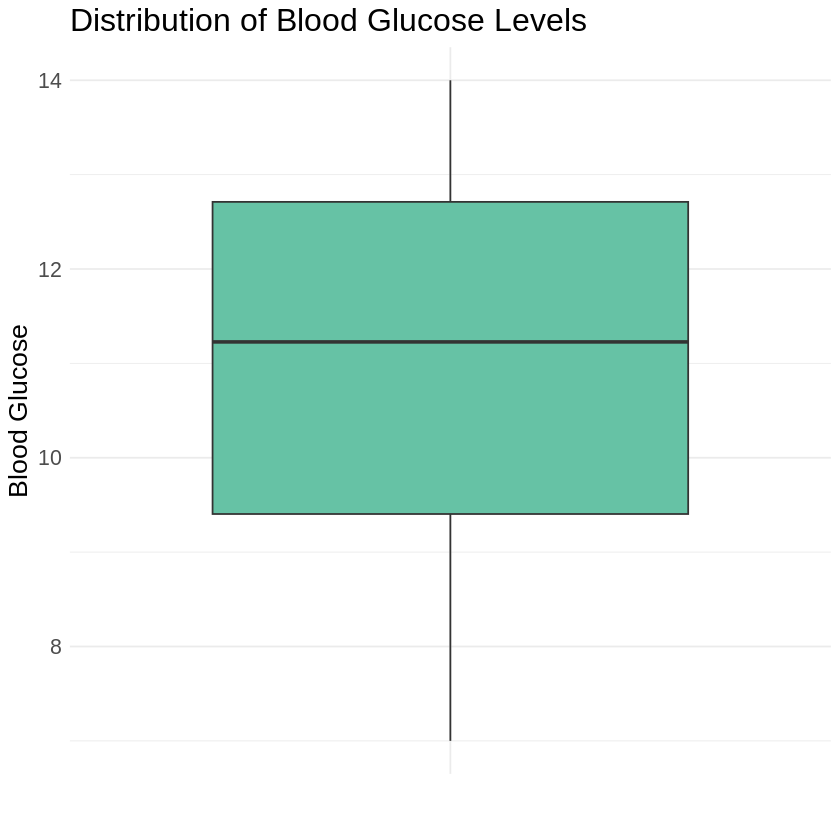

In [10]:
# Identify outliers by visualising the distribution of BloodGlucose with a boxplot.
library(ggplot2)

# Create a boxplot of BloodGlucose, colored by Group
ggplot(df_dropNaN, aes(x = "", y = BloodGlucose)) +
  geom_boxplot(fill = "#66c2a5") + # Use color-blind friendly colors
  labs(title = "Distribution of Blood Glucose Levels", x = "", y = "Blood Glucose") +
  theme_minimal() +
  theme(text = element_text(size = 16)) # Increase font size for all text elements

In [11]:
# Use the IQR method to remove outliers
# NOTE: The quantile function, by default, does not handle missing values. So, use na.rm = TRUE
Q1 <- quantile(df_dropNaN$BloodGlucose, 0.25, na.rm = TRUE)
Q3 <- quantile(df_dropNaN$BloodGlucose, 0.75, na.rm = TRUE)
IQR_val <- IQR(df_dropNaN$BloodGlucose, na.rm = TRUE)

lower_bound <- Q1 - 1.5 * IQR_val
upper_bound <- Q3 + 1.5 * IQR_val

# Identify and remove outliers
outliers <- df_dropNaN %>% filter(BloodGlucose < lower_bound | BloodGlucose > upper_bound)
df_no_outliers <- df_dropNaN %>% filter(BloodGlucose >= lower_bound & BloodGlucose <= upper_bound)

cat(sprintf("Number of outliers removed: %d\n\n", nrow(outliers)))

Number of outliers removed: 0



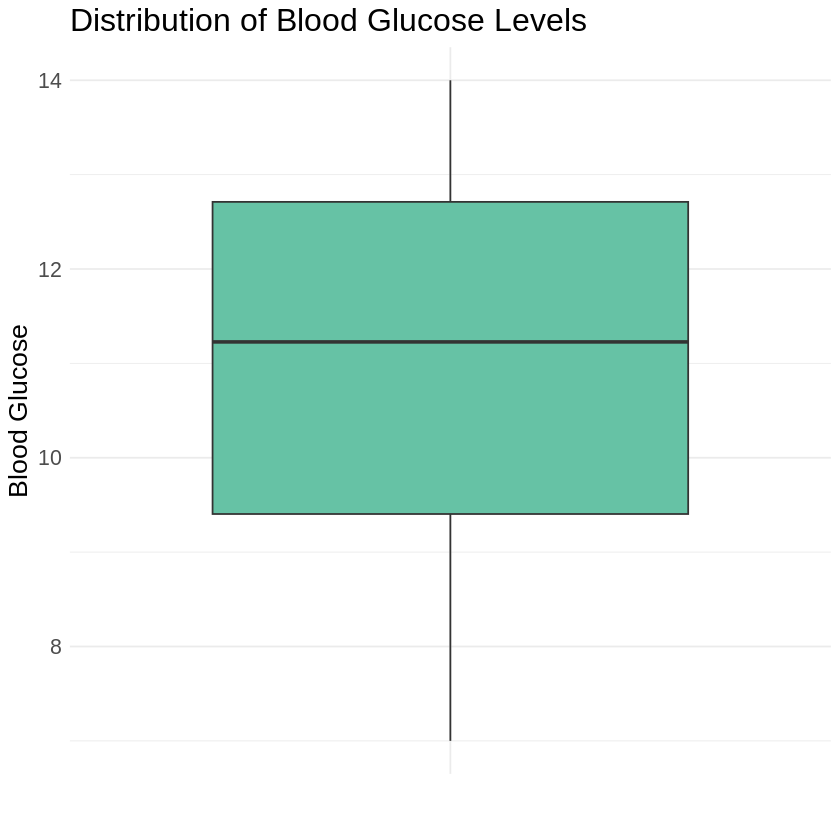

In [12]:
# Re-examine the boxplot without outliers
ggplot(df_no_outliers, aes(x = "", y = BloodGlucose)) +
  geom_boxplot(fill = "#66c2a5") + # Use color-blind friendly colors
  labs(title = "Distribution of Blood Glucose Levels", x = "", y = "Blood Glucose") +
  theme_minimal() +
  theme(text = element_text(size = 16)) # Increase font size for all text elements

## Test for normality and homogeneity of variance

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


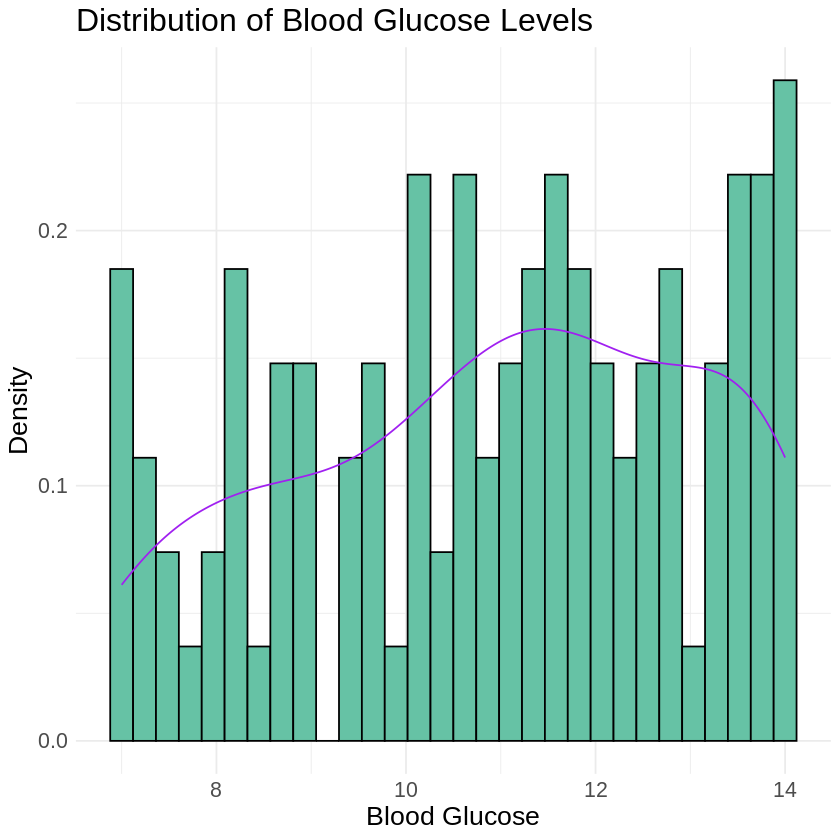

In [13]:
# Visualise the distribution of BloodGlucose with a histogram
ggplot(df_no_outliers, aes(x = BloodGlucose)) +
  geom_histogram(aes(y = ..density..), bins = 30, fill = "#66c2a5", color = "black") +
  geom_density(color = "purple") +
  labs(title = "Distribution of Blood Glucose Levels", x = "Blood Glucose", y = "Density") +
  theme_minimal() +
  theme(text = element_text(size = 16)) # Increase font size for all text elements

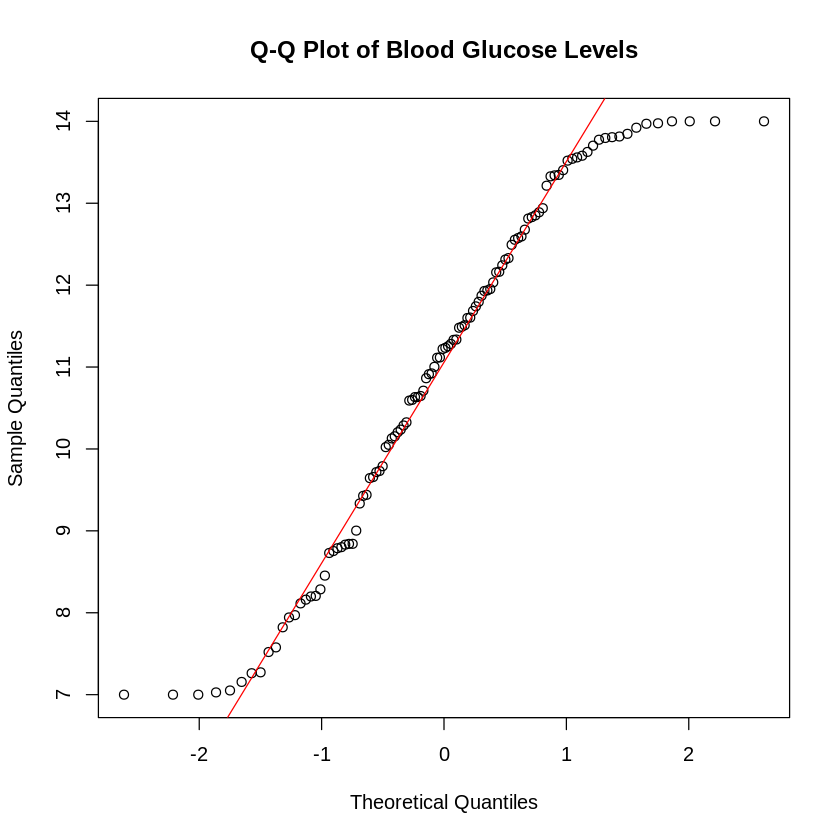

In [14]:
# Visualise the distribution of residuals with a Q-Q plot
qqnorm(df_no_outliers$BloodGlucose, main = "Q-Q Plot of Blood Glucose Levels")
qqline(df_no_outliers$BloodGlucose, col = "red")

In [15]:
# test BloodGlucose for normality using Shapiro-Wilk test
shapiro_test <- shapiro.test(df_no_outliers$BloodGlucose)
print(shapiro_test)

if(shapiro_test$p.value > alpha) {
  cat("Sample looks Gaussian (fail to reject H0)\n")
} else {
  cat("Sample does not look Gaussian (reject H0)\n")
}


	Shapiro-Wilk normality test

data:  df_no_outliers$BloodGlucose
W = 0.94745, p-value = 0.0002435

Sample does not look Gaussian (reject H0)


In [16]:
# test BloodGlucose for homogeneity of variance using Bartlett's test if Shapiro-Wilk Test Statistic p-value>0.05 or use Levene's Test if Shapiro-Wilk Test Statistic p-value<0.05

# install necessary package if not already installed
if(!require(car)){install.packages("car")}

if(shapiro_test$p.value > alpha) {
  bartlett_res <- bartlett.test(BloodGlucose ~ Group, data = df_no_outliers)
  print(bartlett_res)
  if(bartlett_res$p.value > alpha) {
    cat("Samples have equal variance (fail to reject H0)\n")
  } else {
    cat("Samples do not have equal variance (reject H0)\n")
  }
} else {
  # Levene's Test from the car package
  library(car)
  levene_res <- leveneTest(BloodGlucose ~ Group, data = df_no_outliers)
  print(levene_res)
  # Extract the p-value from the test output
  p_levene <- levene_res$`Pr(>F)`[1]
  if(p_levene > alpha) {
    cat("Samples have equal variance (fail to reject H0)\n")
  } else {
    cat("Samples do not have equal variance (reject H0)\n")
  }
}

Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


Levene's Test for Homogeneity of Variance (center = median)
       Df F value Pr(>F)
group   1  0.4176 0.5195
      110               
Samples have equal variance (fail to reject H0)


Data are not normally distributed so need to be transformed or scaled.

## Log-transform data

In [17]:
# Create a new column with log-transformed blood glucose values

df_no_outliers <- df_no_outliers %>%
  mutate(log_BloodGlucose = log(BloodGlucose))

print(head(df_no_outliers))

  ID   Group     Time BloodGlucose log_BloodGlucose
1  1 Control Baseline    13.403642         2.595526
2  1 Control   Week12    13.775643         2.622902
3  2 Control Baseline    13.559528         2.607089
4  2 Control   Week12    14.000000         2.639057
5  3 Control Baseline     9.002977         2.197555
6  3 Control   Week12     9.643944         2.266330


In [18]:
# Ensure 'Group' and 'Time' are treated as categorical factors
df_no_outliers$Group <- as.factor(df_no_outliers$Group)
df_no_outliers$Time  <- as.factor(df_no_outliers$Time)

# Check the structure of the final dataframe
str(df_no_outliers)

'data.frame':	112 obs. of  5 variables:
 $ ID              : int  1 1 2 2 3 3 4 4 5 5 ...
 $ Group           : Factor w/ 2 levels "Control","Treatment": 1 1 1 1 1 1 1 1 1 1 ...
 $ Time            : Factor w/ 2 levels "Baseline","Week12": 1 2 1 2 1 2 1 2 1 2 ...
 $ BloodGlucose    : num  13.4 13.8 13.6 14 9 ...
 $ log_BloodGlucose: num  2.6 2.62 2.61 2.64 2.2 ...


# Statistical analysis

## Two-way repeated-measures ANOVA

In [19]:
# Perform a two-way (Group_Encoded  x Time_Encoded) mixed ANOVA on BloodGlucose  with posthoc using dependent T-tests between groups and a Bonferroni correction for multiple comparisons

# Fit the ANOVA model
model <- aov(log_BloodGlucose ~ Group * Time, data = df_no_outliers)
anova_results <- summary(model)[[1]]
rownames(anova_results) <- trimws(rownames(anova_results)) # Remove trailing (and leading) whitespace from row names
print(anova_results)

# Interpret the p-values
alpha <- 0.05  # Significance level

# Loop through each term in the ANOVA table
for (term in rownames(anova_results)) {
  p_value <- anova_results[term, "Pr(>F)"]
  if (!is.na(p_value) && p_value < alpha) {
    cat(sprintf("\nFactor/Interaction '%s' is statistically significant (p-value = %.4f).\n", term, p_value))
  } else {
    cat(sprintf("\nFactor/Interaction '%s' is not statistically significant (p-value = %.4f).\n", term, p_value))
  }
}

# Post hoc analysis - Pairwise comparisons using Tukey's HSD
# Post hoc for 'Group' if significant
# Access the p-value for 'Group' using row and column names or indices that exist
if (anova_results["Group", 5] < alpha) { # Assuming "Pr(>F)" is the 5th column. Replace with correct index if needed
  cat("\nPost Hoc Test - Pairwise Comparison for 'Group' (Control vs Treatment):\n")
  # Perform Tukey's HSD on an ANOVA model with only 'Group'
  tukey_group <- TukeyHSD(aov(log_BloodGlucose ~ Group, data = df_no_outliers))
  print(tukey_group)
}

# Post hoc for 'Time' if significant
# Access the p-value for 'Time' using row and column names or indices that exist
if (anova_results["Time", 5] < alpha) { # Assuming "Pr(>F)" is the 5th column. Replace with correct index if needed
  cat("\nPost Hoc Test - Pairwise Comparison for 'Time' (Baseline vs Week12):\n")
  tukey_time <- TukeyHSD(aov(log_BloodGlucose ~ Time, data = df_no_outliers))
  print(tukey_time)
}

# Post hoc for the 'Group:Time' interaction if significant
# Access the p-value for 'Group:Time' using row and column names or indices that exist
if (anova_results["Group:Time", 5] < alpha) { # Assuming "Pr(>F)" is the 5th column. Replace with correct index if needed
  cat("\nPost Hoc Test - Pairwise Comparison for 'Group x Time' interaction:\n")
  # Create a new grouping variable by combining 'Group' and 'Time'
  df_no_outliers$Group_Time <- with(df_no_outliers, paste(Group, Time, sep = "_"))
  tukey_interaction <- TukeyHSD(aov(log_BloodGlucose ~ Group_Time, data = df_no_outliers))
  print(tukey_interaction)
}

            Df Sum Sq  Mean Sq F value  Pr(>F)   
Group        1 0.2789 0.278921  7.0913 0.00893 **
Time         1 0.0064 0.006408  0.1629 0.68729   
Group:Time   1 0.1011 0.101081  2.5699 0.11183   
Residuals  108 4.2479 0.039333                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Factor/Interaction 'Group' is statistically significant (p-value = 0.0089).

Factor/Interaction 'Time' is not statistically significant (p-value = 0.6873).

Factor/Interaction 'Group:Time' is not statistically significant (p-value = 0.1118).

Factor/Interaction 'Residuals' is not statistically significant (p-value = NA).

Post Hoc Test - Pairwise Comparison for 'Group' (Control vs Treatment):
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = log_BloodGlucose ~ Group, data = df_no_outliers)

$Group
                         diff        lwr         upr     p adj
Treatment-Control -0.09980709 -0.1743303 -0.02528392 0.0091299



### Effect sizes and Statistical power

In [20]:
# Calculate effect size (eta-squared) for Group, Time, and Group:Time in the ANOVA model
anova_results$`Eta^2` <- anova_results$`Sum Sq` / sum(anova_results$`Sum Sq`)

# Print the ANOVA table with eta-squared
print(anova_results)

# Extract eta-squared for specific terms
eta_squared_group <- anova_results["Group", "Eta^2"]
eta_squared_time <- anova_results["Time", "Eta^2"]
eta_squared_interaction <- anova_results["Group:Time", "Eta^2"]

# Function to interpret effect size
interpret_effect_size <- function(eta_squared) {
  if (eta_squared < 0.01) {
    "(a trivial effect)."
  } else if (eta_squared < 0.06) {
    "(a small effect)."
  } else if (eta_squared < 0.14) {
    "(a medium effect)."
  } else {
    "(a large effect)."
  }
}

# Print the values and interpretations
cat("\nEta-squared for Group:", eta_squared_group, interpret_effect_size(eta_squared_group), "\n")
cat("Eta-squared for Time:", eta_squared_time, interpret_effect_size(eta_squared_time), "\n")
cat("Eta-squared for Group:Time Interaction:", eta_squared_interaction, interpret_effect_size(eta_squared_interaction), "\n")

            Df Sum Sq  Mean Sq F value  Pr(>F)   Eta^2
Group        1 0.2789 0.278921  7.0913 0.00893 0.06019
Time         1 0.0064 0.006408  0.1629 0.68729 0.00138
Group:Time   1 0.1011 0.101081  2.5699 0.11183 0.02181
Residuals  108 4.2479 0.039333                 0.91662

Eta-squared for Group: 0.06018577 (a medium effect). 
Eta-squared for Time: 0.001382683 (a trivial effect). 
Eta-squared for Group:Time Interaction: 0.02181138 (a small effect). 


In [21]:
# convert eta-squared to cohen's d
eta_squared_to_cohens_d <- function(eta_squared, n) {
  # Convert partial eta-squared to Cohen's d for two groups:
  # Cohen's d = sqrt(eta_squared / (1 - eta_squared)) * sqrt(2)
  sqrt(eta_squared / (1 - eta_squared)) * sqrt(2)
}

interpret_cohens_d <- function(cohens_d) {
  if (abs(cohens_d) < 0.2) {
    return("Trivial effect")
  } else if (abs(cohens_d) < 0.5) {
    return("Small effect")
  } else if (abs(cohens_d) < 0.8) {
    return("Medium effect")
  } else {
    return("Large effect")
  }
}

# Here we assume n_group is the number of observations used for the effect size calculations.
# (Be mindful that in repeated-measures designs, df or subject count may be more appropriate.)
n_group <- nrow(df_no_outliers)  # In our data, each row is one measurement.

cohens_d_group       <- eta_squared_to_cohens_d(eta_squared_group, n_group)
cohens_d_time        <- eta_squared_to_cohens_d(eta_squared_time, n_group)
cohens_d_interaction <- eta_squared_to_cohens_d(eta_squared_interaction, n_group)

# Interpret Cohen's d values
cohens_interpretation_group       <- interpret_cohens_d(cohens_d_group)
cohens_interpretation_time        <- interpret_cohens_d(cohens_d_time)
cohens_interpretation_interaction <- interpret_cohens_d(cohens_d_interaction)

cat(sprintf("Cohen's d for Group effect: %.3f, which is a %s.\n",
            cohens_d_group, cohens_interpretation_group))
cat(sprintf("Cohen's d for Time effect: %.3f, which is a %s.\n",
            cohens_d_time, cohens_interpretation_time))
cat(sprintf("Cohen's d for Interaction effect: %.3f, which is a %s.\n",
            cohens_d_interaction, cohens_interpretation_interaction))

Cohen's d for Group effect: 0.358, which is a Small effect.
Cohen's d for Time effect: 0.053, which is a Trivial effect.
Cohen's d for Interaction effect: 0.211, which is a Small effect.


In [22]:
# Calculate statistical power for main effects and interaction
# Note: For power analysis using pwr.anova.test(), the effect size must be Cohen's f.
# For two groups, Cohen's f can be approximated as f = d/2.
f_group <- cohens_d_group / 2
f_time  <- cohens_d_time / 2

alpha <- 0.05
n_per_group_sample <- 56  # sample size per group (as in the Python example)

# Power analysis for the main effect of Time
power_time <- pwr.anova.test(k = 2, f = f_time, n = n_per_group_sample, sig.level = alpha)$power
cat(sprintf("Statistical power for main effect of Time: %.3f\n", power_time))

# Power analysis for the main effect of Group
power_group <- pwr.anova.test(k = 2, f = f_group, n = n_per_group_sample, sig.level = alpha)$power
cat(sprintf("Statistical power for main effect of Group: %.3f\n", power_group))

Statistical power for main effect of Time: 0.059
Statistical power for main effect of Group: 0.467


## Linear mixed model

In [23]:
# install packages
if(!require(lmerTest)){install.packages("lmerTest")}
library(lmerTest)  # For linear mixed models with p-values
library(lme4)      # Underlying mixed-model functions

Loading required package: lmerTest

Loading required package: lme4

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




In [24]:
# use a linear mixed model to analyse the change in BloodGlucose
# Fit the linear mixed model
lmm_model <- lmer(log_BloodGlucose ~ Group * Time + (1 | ID), data = df_no_outliers)

# Print the model summary
print(summary(lmm_model))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_BloodGlucose ~ Group * Time + (1 | ID)
   Data: df_no_outliers

REML criterion at convergence: -230.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.15216 -0.32376 -0.01006  0.36089  1.96797 

Random effects:
 Groups   Name        Variance  Std.Dev.
 ID       (Intercept) 0.0401065 0.2003  
 Residual             0.0004041 0.0201  
Number of obs: 112, groups:  ID, 58

Fixed effects:
                           Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)                2.402423   0.037375 56.489502  64.278  < 2e-16 ***
GroupTreatment            -0.041832   0.052857 56.489502  -0.791    0.432    
TimeWeek12                 0.039882   0.005470 52.003879   7.291  1.7e-09 ***
GroupTreatment:TimeWeek12 -0.126649   0.007736 52.003879 -16.371  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
       

In [25]:
# Post-hoc tests with Bonferroni correction
# Extract the fixed effects table from the model summary.
fixed_effects <- summary(lmm_model)$coefficients
# Exclude the intercept (first row)
p_values <- fixed_effects[-1, "Pr(>|t|)"]
print(p_values)

# Number of comparisons (non-intercept coefficients)
num_comparisons <- length(p_values)
bonferroni_alpha <- 0.05 / num_comparisons

cat("\nPost-hoc tests with Bonferroni correction:\n")
for (coef_name in names(p_values)) {
  p_val <- p_values[coef_name]
  adjusted_p <- p_val * num_comparisons  # Bonferroni adjustment
  cat(sprintf("%s: p-value = %.4f, Adjusted p-value = %.4f",
              coef_name, p_val, adjusted_p))
  if (adjusted_p < 0.05) {
    cat(" (Significant after Bonferroni correction)\n")
  } else {
    cat(" (Not significant after Bonferroni correction)\n")
  }
}

           GroupTreatment                TimeWeek12 GroupTreatment:TimeWeek12 
             4.320048e-01              1.702320e-09              3.630995e-22 

Post-hoc tests with Bonferroni correction:
GroupTreatment: p-value = 0.4320, Adjusted p-value = 1.2960 (Not significant after Bonferroni correction)
TimeWeek12: p-value = 0.0000, Adjusted p-value = 0.0000 (Significant after Bonferroni correction)
GroupTreatment:TimeWeek12: p-value = 0.0000, Adjusted p-value = 0.0000 (Significant after Bonferroni correction)


### Effect sizes and Statistical power

In [26]:
# install packages
if(!require(emmeans)){install.packages("emmeans")}
library(emmeans)

Loading required package: emmeans

Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'



In [27]:
# Calculate Cohen's d for the LMM model
# NOTE: Cohen's d is not directly provided by mixedlm summary.  We need to calculate it from the coefficients and standard errors.

# Extract the relevant coefficients and standard errors
group_effect_coefficient <- fixed_effects["GroupTreatment", "Estimate"]
group_effect_stderr      <- fixed_effects["GroupTreatment", "Std. Error"]

time_effect_coefficient <- fixed_effects["TimeWeek12", "Estimate"]
time_effect_stderr      <- fixed_effects["TimeWeek12", "Std. Error"]

interaction_effect_coefficient <- fixed_effects["GroupTreatment:TimeWeek12", "Estimate"]
interaction_effect_stderr      <- fixed_effects["GroupTreatment:TimeWeek12", "Std. Error"]

cohens_d_group_lmm       <- group_effect_coefficient / group_effect_stderr
cohens_d_time_lmm        <- time_effect_coefficient / time_effect_stderr
cohens_d_interaction_lmm <- interaction_effect_coefficient / interaction_effect_stderr

# Define a function to interpret Cohen's d effect sizes
interpret_cohens_d <- function(d) {
  abs_d <- abs(d)
  if (abs_d < 0.2) {
    return("Trivial effect")
  } else if (abs_d < 0.5) {
    return("Small effect")
  } else if (abs_d < 0.8) {
    return("Medium effect")
  } else {
    return("Large effect")
  }
}

cat(sprintf("Cohen's d for Group effect (LMM): %.3f, %s\n",
            cohens_d_group_lmm, interpret_cohens_d(cohens_d_group_lmm)))
cat(sprintf("Cohen's d for Time effect (LMM): %.3f, %s\n",
            cohens_d_time_lmm, interpret_cohens_d(cohens_d_time_lmm)))
cat(sprintf("Cohen's d for Interaction effect (LMM): %.3f, %s\n",
            cohens_d_interaction_lmm, interpret_cohens_d(cohens_d_interaction_lmm)))

Cohen's d for Group effect (LMM): -0.791, Medium effect
Cohen's d for Time effect (LMM): 7.291, Large effect
Cohen's d for Interaction effect (LMM): -16.371, Large effect


In [28]:
# Calculate statistical power for main effects and interaction using Cohen's d from the LMM

# For two groups, Cohen's f (required by pwr.anova.test) can be approximated as d/2.
# Take the absolute value of Cohen's d before dividing by 2 to ensure f is positive
f_group       <- abs(cohens_d_group_lmm) / 2
f_time        <- abs(cohens_d_time_lmm) / 2
f_interaction <- abs(cohens_d_interaction_lmm) / 2

alpha <- 0.05
n_per_group <- 56  # sample size per group

# Power analysis for main effect of Time using Cohen's d from LMM
power_time_lmm <- pwr.anova.test(k = 2, f = f_time, n = n_per_group, sig.level = alpha)$power
cat(sprintf("Statistical power for main effect of Time (LMM): %.4f\n", power_time_lmm))

# Power analysis for main effect of Group using Cohen's d from LMM
power_group_lmm <- pwr.anova.test(k = 2, f = f_group, n = n_per_group, sig.level = alpha)$power
cat(sprintf("Statistical power for main effect of Group (LMM): %.4f\n", power_group_lmm))

# Power analysis for the interaction using Cohen's d from LMM
power_interaction_lmm <- pwr.anova.test(k = 2, f = f_interaction, n = n_per_group, sig.level = alpha)$power
cat(sprintf("Statistical power for interaction effect (LMM): %.4f\n", power_interaction_lmm))

Statistical power for main effect of Time (LMM): 1.0000
Statistical power for main effect of Group (LMM): 0.9858
Statistical power for interaction effect (LMM): 1.0000


## Bayesian model

In [29]:
# Load libraries
if (!requireNamespace("brms", quietly = TRUE)) {
  install.packages("brms")
}
library(brms)         # For Bayesian modeling
library(rstan)        # For accessing sampler parameters (e.g., energy diagnostics)
library(bayesplot)    # For posterior plots

# Install and load bayestestR if it's not already installed
if (!requireNamespace("bayestestR", quietly = TRUE)) {
  install.packages("bayestestR")
}
library(bayestestR)   # For computing HDI intervals

Loading required package: Rcpp

Loading 'brms' package (version 2.22.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:lme4’:

    ngrps


The following object is masked from ‘package:stats’:

    ar


Loading required package: StanHeaders


rstan version 2.32.7 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)



Attaching package: ‘rstan’


The following object is masked from ‘package:tidyr’:

    extract


This is bayesplot version 1.12.0

- Online documentation

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.6e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 6000 [  0%]  (Warmup)
Chain 1: Iteration:  600 / 6000 [ 10%]  (Warmup)
Chain 1: Iteration: 1200 / 6000 [ 20%]  (Warmup)
Chain 1: Iteration: 1800 / 6000 [ 30%]  (Warmup)
Chain 1: Iteration: 2001 / 6000 [ 33%]  (Sampling)
Chain 1: Iteration: 2600 / 6000 [ 43%]  (Sampling)
Chain 1: Iteration: 3200 / 6000 [ 53%]  (Sampling)
Chain 1: Iteration: 3800 / 6000 [ 63%]  (Sampling)
Chain 1: Iteration: 4400 / 6000 [ 73%]  (Sampling)
Chain 1: Iteration: 5000 / 6000 [ 83%]  (Sampling)
Chain 1: Iteration: 5600 / 6000 [ 93%]  (Sampling)
Chain 1: Iteration: 6000 / 6000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.059 seconds (Warm-up)
Chain 1:                0.118 seconds (Sampling)
Chain 1:                

Warning message:
“Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives.”


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log_BloodGlucose ~ 0 + Group 
   Data: df_no_outliers (Number of observations: 112) 
  Draws: 4 chains, each with iter = 6000; warmup = 2000; thin = 1;
         total post-warmup draws = 16000

Regression Coefficients:
               Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
GroupControl       2.42      0.03     2.37     2.48 1.00    16477    11244
GroupTreatment     2.32      0.03     2.27     2.38 1.00    15968    10364

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.20      0.01     0.18     0.23 1.00    14992    10811

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

BFMI: 1.04, i.e., Anecdotal evidence in favor of the alternative hypothesis (a treatment effect).

Bayes

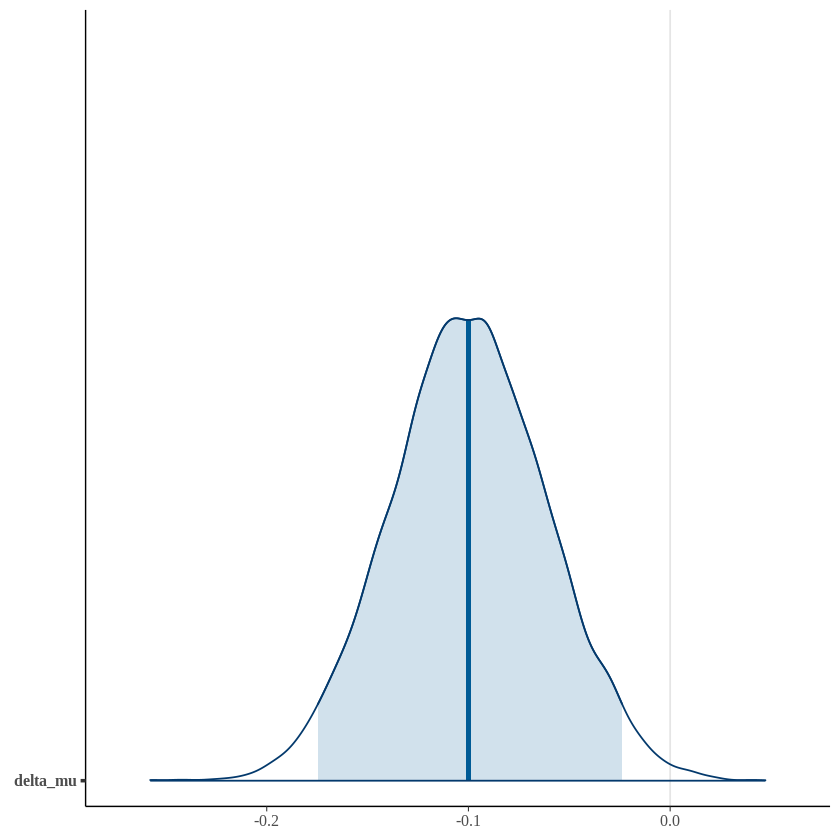

In [30]:
# Use a Bayesian model to compare log_BloodGlucose between groups (Treatment vs Control) in df_no_outliers.

# Prepare the data for the Bayesian model
# Subset log_BloodGlucose values for each group if needed
treatment_glucose <- df_no_outliers$log_BloodGlucose[df_no_outliers$Group == "Treatment"]
control_glucose   <- df_no_outliers$log_BloodGlucose[df_no_outliers$Group == "Control"]

# In brms we can model both groups by using Group as a predictor.
# We use a model with no intercept so that we obtain separate estimates for each group.
bayes_model <- brm(
  formula = log_BloodGlucose ~ 0 + Group,
  data = df_no_outliers,
  prior = c(
    # Priors for group means (analogous to mu_treatment and mu_control)
    prior(normal(0, 10), class = "b"),
    # Prior for the residual standard deviation; note: sigma is positive by default
    prior(normal(0, 5), class = "sigma", lb = 0)
  ),
  iter = 6000,     # Total iterations (4000 draws + 2000 warmup)
  warmup = 2000,
  chains = 4,
  control = list(adapt_delta = 0.95)
)

# Compute delta_mu as the difference between group means:
# In a no-intercept model, the coefficients are named "b_GroupControl" and "b_GroupTreatment"
posterior <- as.data.frame(posterior_samples(bayes_model))
posterior$delta_mu <- posterior$b_GroupTreatment - posterior$b_GroupControl

# Print the model summary
print(summary(bayes_model))


# Calculate Bayes factor
# BFMI is not automatically computed in R, but we can approximate it from the energy diagnostics.
sampler_params <- rstan::get_sampler_params(bayes_model$fit, inc_warmup = FALSE)
bfmi_values <- sapply(sampler_params, function(chain) {
  energy <- chain[, "energy__"]
  # Compute BFMI for this chain:
  bfmi_chain <- mean(diff(energy)^2) / var(energy)
  return(bfmi_chain)
})
bfmi_value <- mean(bfmi_values)


# Interpret Bayes factor (using Jeffreys' scale):
interpret_bfmi <- function(bfmi_value) {
  if (bfmi_value > 30) {
    return("Very strong evidence in favor of the alternative hypothesis (a treatment effect).")
  } else if (bfmi_value > 10) {
    return("Strong evidence in favor of the alternative hypothesis (a treatment effect).")
  } else if (bfmi_value > 3) {
    return("Moderate evidence in favor of the alternative hypothesis (a treatment effect).")
  } else if (bfmi_value > 1) {
    return("Anecdotal evidence in favor of the alternative hypothesis (a treatment effect).")
  } else if (bfmi_value < 1/30) {
    return("Very strong evidence in favor of the null hypothesis (no treatment effect).")
  } else if (bfmi_value < 1/10) {
    return("Strong evidence in favor of the null hypothesis (no treatment effect).")
  } else if (bfmi_value < 1/3) {
    return("Moderate evidence in favor of the null hypothesis (no treatment effect).")
  } else {
    return("Evidence for the alternative and null hypotheses is unclear.")
  }
}

BFMI_interpretation <- interpret_bfmi(bfmi_value)
cat(sprintf("\nBFMI: %.2f, i.e., %s\n", bfmi_value, BFMI_interpretation))



# Plot the Bayesian posterior distribution
cat("\nBayesian posterior distribution plot:\n")
# Convert posterior$delta_mu to a data frame with a column name
delta_mu_df <- data.frame(delta_mu = posterior$delta_mu)
mcmc_areas(as.matrix(delta_mu_df), prob = 0.95, prob_outer = 1)


# Determine whether the 95% HDI in the Bayesian posterior distribution plot excludes zero
hdi_delta <- hdi(posterior$delta_mu, ci = 0.95)
lower_bound <- hdi_delta$CI_low
upper_bound <- hdi_delta$CI_high

cat(sprintf("\n95%% HDI for delta_mu: (%.3f, %.3f)\n", lower_bound, upper_bound))
if (lower_bound > 0 || upper_bound < 0) {
  cat("The 95% HDI excludes zero.\n")
} else {
  cat("The 95% HDI includes zero.\n")
}

### Statistical power

In [31]:
# Calculate the statistical power of the Bayes model
# Define power here as the posterior probability that delta_mu > 0.
power <- mean(posterior$delta_mu > 0)
cat(sprintf("Statistical power of the Bayesian model: %.4f\n", power))

Statistical power of the Bayesian model: 0.0050


## Standardized mean difference (effect size)

In [32]:
# Calculate Pooled_Baseline_SD (the standard deviation of 'BloodGlucose' at 'Baseline') in df_no_outliers
Pooled_Baseline_SD <- sd(df_no_outliers$BloodGlucose[df_no_outliers$Time == "Baseline"])
cat("Pooled Baseline SD:", Pooled_Baseline_SD, "\n")

Pooled Baseline SD: 2.118913 


In [33]:
# Pivot the data so that each row represents one subject with columns for Baseline and Week12
df_pivot <- df_no_outliers %>%
  pivot_wider(id_cols = ID, names_from = Time, values_from = BloodGlucose)

# Merge the group information (assuming it is the same for each subject)
group_info <- df_no_outliers %>% select(ID, Group) %>% distinct()
df_pivot <- df_pivot %>% left_join(group_info, by = "ID")

# Calculate delta_BloodGlucose: Week12 minus Baseline
df_pivot <- df_pivot %>%
  mutate(delta_BloodGlucose = `Week12` - Baseline)

# Create the new dataframe with only the desired columns
delta_df <- df_pivot %>% select(ID, Group, delta_BloodGlucose)
print(head(delta_df))

# A tibble: 6 × 3
     ID Group   delta_BloodGlucose
  <int> <fct>                <dbl>
1     1 Control              0.372
2     2 Control              0.440
3     3 Control              0.641
4     4 Control              0.707
5     5 Control              0.378
6     6 Control              0.601


In [34]:
# Calculate the standardized mean difference for each group

# Separate values by Group
control_values <- delta_df %>% filter(Group == "Control") %>% pull(delta_BloodGlucose)
treatment_values <- delta_df %>% filter(Group == "Treatment") %>% pull(delta_BloodGlucose)

# Calculate mean differences for each group
control_mean_diff <- mean(control_values, na.rm = TRUE)
treatment_mean_diff <- mean(treatment_values, na.rm = TRUE)

# Control group statistics and 95% CI
n_control <- length(control_values)
control_std <- sd(control_values, na.rm = TRUE)
control_se <- control_std / sqrt(n_control)
t_crit_control <- qt(1 - 0.025, df = n_control - 1)
control_ci_lower <- control_mean_diff - t_crit_control * control_se
control_ci_upper <- control_mean_diff + t_crit_control * control_se

# Treatment group statistics and 95% CI
n_treatment <- length(treatment_values)
treatment_std <- sd(treatment_values, na.rm = TRUE)
treatment_se <- treatment_std / sqrt(n_treatment)
t_crit_treatment <- qt(1 - 0.025, df = n_treatment - 1)
treatment_ci_lower <- treatment_mean_diff - t_crit_treatment * treatment_se
treatment_ci_upper <- treatment_mean_diff + t_crit_treatment * treatment_se

cat(sprintf("Mean difference for Control [95%% CI]: %.3f [%.3f, %.3f]\n",
            control_mean_diff, control_ci_lower, control_ci_upper))
cat(sprintf("Mean difference for Treatment [95%% CI]: %.3f [%.3f, %.3f]\n",
            treatment_mean_diff, treatment_ci_lower, treatment_ci_upper))

# Calculate Standardized Mean Difference (SMD)
# Pooled_Baseline_SD calculated earlier

# Compute SMD for each group as the mean difference divided by the pooled baseline SD
control_SMD <- control_mean_diff / Pooled_Baseline_SD
treatment_SMD <- treatment_mean_diff / Pooled_Baseline_SD

# Define Functions to Interpret SMD and Direction of Change
interpret_SMD <- function(SMD) {
  if (abs(SMD) < 0.2) {
    return("Trivial")
  } else if (abs(SMD) < 0.5) {
    return("Small")
  } else if (abs(SMD) < 0.8) {
    return("Medium")
  } else {
    return("Large")
  }
}

interpret_direction <- function(mean_diff) {
  if (mean_diff < 0) {
    return("decrease in blood glucose")
  } else if (mean_diff > 0) {
    return("increase in blood glucose")
  } else {
    return("no change in blood glucose")
  }
}

SMD_interpretation_Control <- interpret_SMD(control_SMD)
SMD_interpretation_Treatment <- interpret_SMD(treatment_SMD)

direction_interpretation_Control <- interpret_direction(control_mean_diff)
direction_interpretation_Treatment <- interpret_direction(treatment_mean_diff)

# Calculate 95% CI for the SMD
# The standard error for SMD is the SE for the mean difference divided by the pooled baseline SD
control_SMD_se <- control_se / Pooled_Baseline_SD
treatment_SMD_se <- treatment_se / Pooled_Baseline_SD

control_SMD_ci_lower <- control_SMD - t_crit_control * control_SMD_se
control_SMD_ci_upper <- control_SMD + t_crit_control * control_SMD_se

treatment_SMD_ci_lower <- treatment_SMD - t_crit_treatment * treatment_SMD_se
treatment_SMD_ci_upper <- treatment_SMD + t_crit_treatment * treatment_SMD_se

cat(sprintf("\nSMD (effect size) for Control [95%% CI]: %.3f [%.3f, %.3f], which is a %s %s\n",
            control_SMD, control_SMD_ci_lower, control_SMD_ci_upper,
            SMD_interpretation_Control, direction_interpretation_Control))
cat(sprintf("SMD (effect size) for Treatment [95%% CI]: %.3f [%.3f, %.3f], which is a %s %s\n",
            treatment_SMD, treatment_SMD_ci_lower, treatment_SMD_ci_upper,
            SMD_interpretation_Treatment, direction_interpretation_Treatment))

Mean difference for Control [95% CI]: 0.433 [0.359, 0.507]
Mean difference for Treatment [95% CI]: -0.916 [-1.047, -0.785]

SMD (effect size) for Control [95% CI]: 0.204 [0.169, 0.239], which is a Small increase in blood glucose
SMD (effect size) for Treatment [95% CI]: -0.432 [-0.494, -0.371], which is a Small decrease in blood glucose


# Data visualisation
<p>Several methods for presenting the results of an RCT.
<p>The prefered option is the <em>Estimation plot</em>, the final option.

## Boxplot

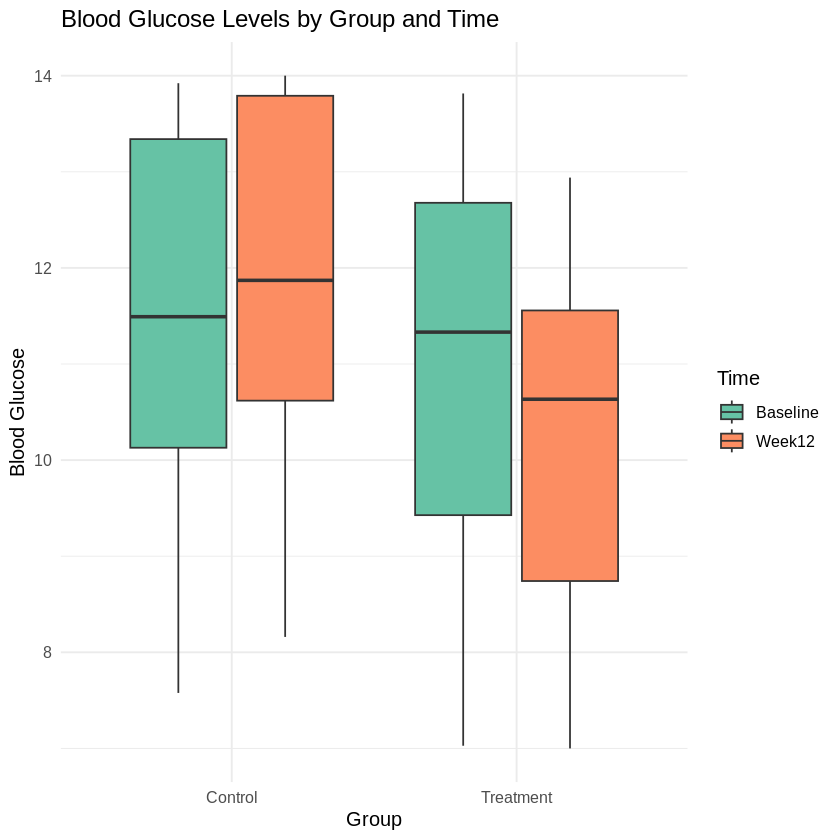

In [35]:
# Create the boxplot
ggplot(df_no_outliers, aes(x = Group, y = BloodGlucose, fill = Time)) +
  geom_boxplot() +
  scale_fill_brewer(palette = "Set2") +  # Set2 is color-blind friendly
  labs(title = "Blood Glucose Levels by Group and Time",
       x = "Group",
       y = "Blood Glucose") +
  theme_minimal(base_size = 12)

## Violin Plot

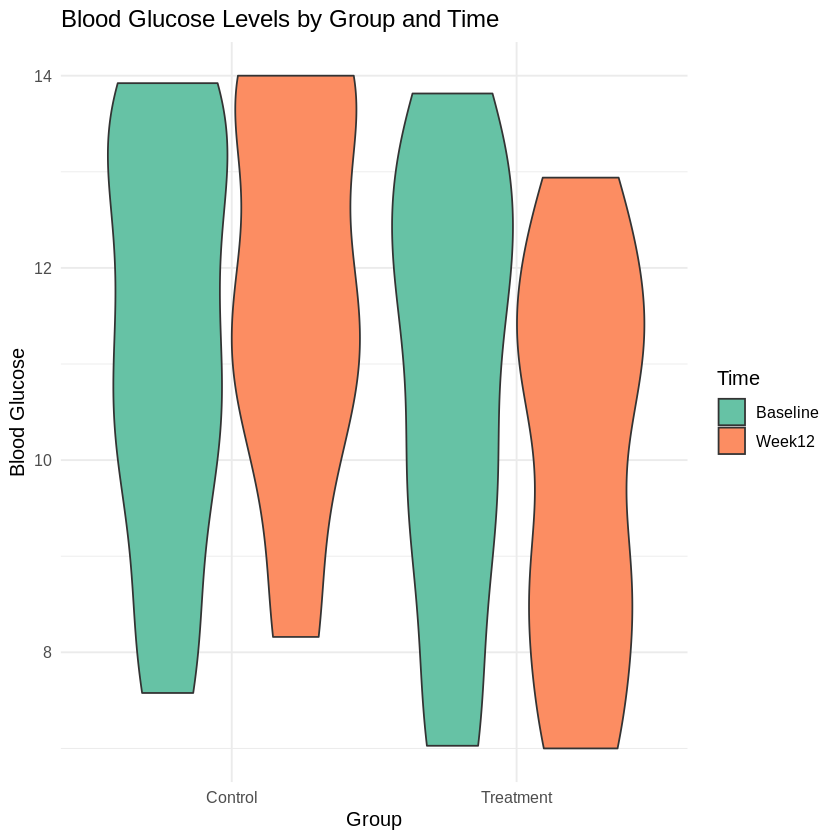

In [36]:
# Create the violin plot
ggplot(df_no_outliers, aes(x = Group, y = BloodGlucose, fill = Time)) +
  geom_violin() +
  scale_fill_brewer(palette = "Set2") + # Set2 is color-blind friendly
  labs(title = "Blood Glucose Levels by Group and Time",
       x = "Group",
       y = "Blood Glucose") +
  theme_minimal(base_size = 12)

## Raincloud plot

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


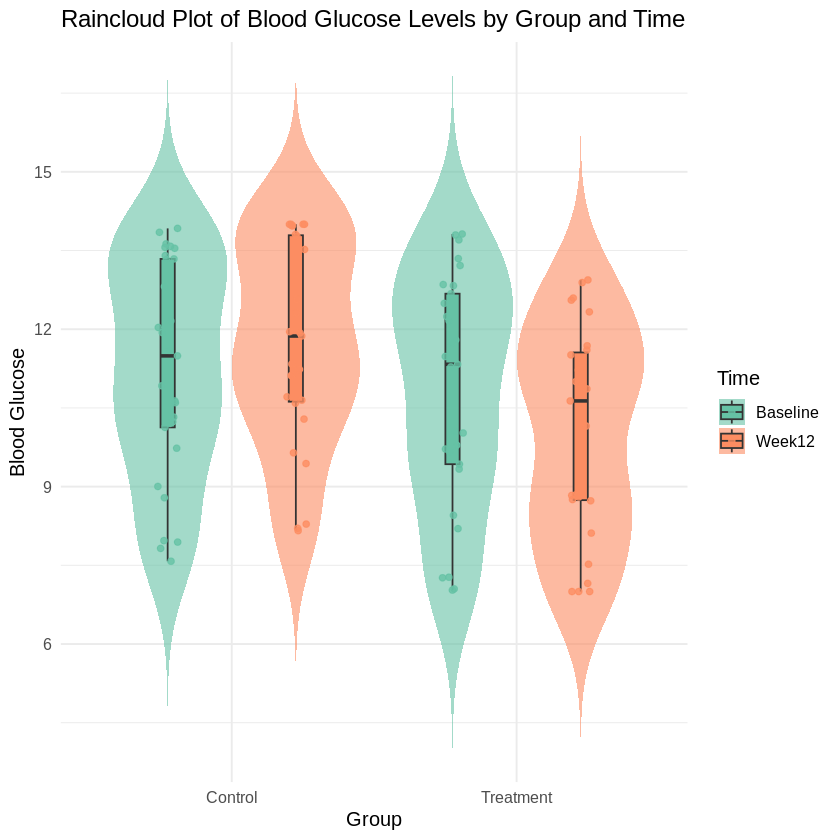

In [37]:
# build a raincloud plot
raincloud_plot <- function(df, x_col, y_col, hue_col) {

  ggplot(df, aes_string(x = x_col, y = y_col, fill = hue_col)) +
    # Create a split violin by dodging the violins side by side
    geom_violin(position = position_dodge(width = 0.9), trim = FALSE, alpha = 0.6, color = NA) +
    # Add a narrow boxplot (optional) for quartiles
    geom_boxplot(width = 0.1, position = position_dodge(width = 0.9), outlier.shape = NA) +
    # Overlay jittered points (raincloud component)
    geom_jitter(aes_string(color = hue_col),
                position = position_jitterdodge(jitter.width = 0.15, dodge.width = 0.9),
                size = 1.5, alpha = 0.8) +
    scale_fill_brewer(palette = "Set2") + # Set2 is color-blind friendly
    scale_color_brewer(palette = "Set2") + # Set2 is color-blind friendly
    labs(title = "Raincloud Plot of Blood Glucose Levels by Group and Time",
         x = "Group",
         y = "Blood Glucose") +
    theme_minimal(base_size = 12)
}

# Create the raincloud plot using the function
raincloud_plot(df_no_outliers, "Group", "BloodGlucose", "Time")

## Estimation plot (Gardner-Altman plot)
https://acclab.github.io/dabestr/

In [38]:
# view dataframe
print(head(df_no_outliers))

  ID   Group     Time BloodGlucose log_BloodGlucose
1  1 Control Baseline    13.403642         2.595526
2  1 Control   Week12    13.775643         2.622902
3  2 Control Baseline    13.559528         2.607089
4  2 Control   Week12    14.000000         2.639057
5  3 Control Baseline     9.002977         2.197555
6  3 Control   Week12     9.643944         2.266330


In [39]:
# reorganise df_no_outliers so it can be read by dabestr
df_no_outliers_2 <- df_no_outliers %>%
  # drop the log column
  select(-log_BloodGlucose) %>%
  # merge Group & Time into one, mapping Baseline→Pre, Week12→Post
  mutate(
    Group = paste0(Group, "_", ifelse(Time == "Baseline", "Pre", "Post")),
    Group = factor(Group,
      levels = c("Control_Pre", "Control_Post", "Treatment_Pre", "Treatment_Post")
    )
  ) %>%
  # drop the old Time
  select(-Time)

# view dataframe
print(head(df_no_outliers_2))

  ID        Group BloodGlucose
1  1  Control_Pre    13.403642
2  1 Control_Post    13.775643
3  2  Control_Pre    13.559528
4  2 Control_Post    14.000000
5  3  Control_Pre     9.002977
6  3 Control_Post     9.643944


In [40]:
# load data into dabest
two_group_two_condition <- load(
  data = df_no_outliers_2,
  x = Group,
  y = BloodGlucose,
  idx = list(
    c("Control_Pre", "Control_Post"),
    c("Treatment_Pre", "Treatment_Post")
  ),
  ci = 95, # 95% confidence interval
  resamples = 5000 # Number of bootstrap resamples
)

### Load data into dabest

In [41]:
# Generate the mean difference
two_group_two_condition.mean_diff <- mean_diff(two_group_two_condition)

# Examine the mean difference
two_group_two_condition.mean_diff

DABESTR v2025.3.14

Good afternoon!
The current time is 13:02 PM on Monday April 28, 2025.

The character(0) mean difference between Control_Post and Control_Pre is 0.477 [95%CI -0.571, 1.465].
The p-value of the two-sided permutation t-test is 0.3750, calculated for legacy purposes only.

The character(0) mean difference between Treatment_Post and Treatment_Pre is -0.801 [95%CI -1.828, 0.258].
The p-value of the two-sided permutation t-test is 0.1574, calculated for legacy purposes only.

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing the effect size (or greater),
assuming the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.


In [42]:
# view all statistical outputs
print(two_group_two_condition.mean_diff$boot_result)

# A tibble: 2 × 11
  control_group test_group   bootstraps nboots bca_ci_low bca_ci_high pct_ci_low
  <chr>         <chr>        <list>      <int>      <dbl>       <dbl>      <dbl>
1 Control_Pre   Control_Post <dbl>        5000     -0.571       1.47      -0.560
2 Treatment_Pre Treatment_P… <dbl>        5000     -1.83        0.258     -1.86 
# ℹ 4 more variables: pct_ci_high <dbl>, ci <dbl>, difference <dbl>,
#   weight <dbl>


In [43]:
# extract the permutation test’s p values
print(two_group_two_condition.mean_diff$permtest_pvals$pval_permtest)

[1] 0.3652 0.1588


In [44]:
# extract the statistical tests
print(two_group_two_condition.mean_diff$permtest_pvals$pval_for_tests)

$pvalue_welch
[1] 0.3749826

$pvalue_welch
[1] 0.157352



In [45]:
# extract the p value results
print(two_group_two_condition.mean_diff$permtest_pvals$pvalues)

[[1]]
[[1]]$pvalue_welch
[1] 0.3749826

[[1]]$statistic_welch
         t 
-0.8945788 

[[1]]$students_t

	Welch Two Sample t-test

data:  control and test
t = -0.89458, df = 53.997, p-value = 0.375
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.5464709  0.5921969
sample estimates:
mean of x mean of y 
 11.24364  11.72078 


[[1]]$pvalue_students_t
[1] 0.3749826

[[1]]$statistic_students_t
         t 
-0.8945788 

[[1]]$pvalue_mann_whitney
[1] 0.2312257

[[1]]$statistic_mann_whitney
  W 
318 


[[2]]
[[2]]$pvalue_welch
[1] 0.157352

[[2]]$statistic_welch
       t 
1.433962 

[[2]]$students_t

	Welch Two Sample t-test

data:  control and test
t = 1.434, df = 53.968, p-value = 0.1574
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.3190115  1.9214460
sample estimates:
mean of x mean of y 
 10.82851  10.02729 


[[2]]$pvalue_students_t
[1] 0.157352

[[2]]$statistic_students_t
     

### Mean difference plot
Edit plot aesthetics at https://acclab.github.io/DABEST-python/tutorials/09-plot_aesthetics.html

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


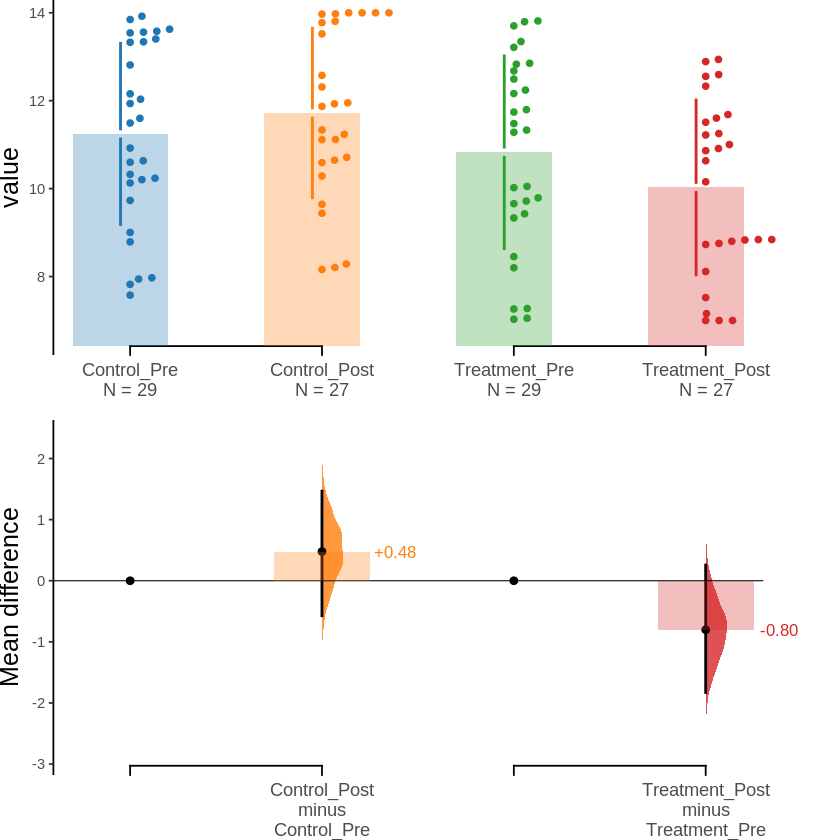

In [46]:
# build the delta-delta estimation plot with mean difference
dabest_plot(two_group_two_condition.mean_diff)

### Hedge's g plot
Edit plot aesthetics at https://acclab.github.io/DABEST-python/tutorials/09-plot_aesthetics.html

In [47]:
# Generate the between groups hedges_g
two_group_two_condition.hedges_g <- hedges_g(two_group_two_condition)

# Examine the between groups hedges_g
two_group_two_condition.hedges_g

DABESTR v2025.3.14

Good afternoon!
The current time is 13:02 PM on Monday April 28, 2025.

The character(0) Hedges'g between Control_Post and Control_Pre is 0.235 [95%CI -0.298, 0.74].
The p-value of the two-sided permutation t-test is 0.3750, calculated for legacy purposes only.

The character(0) Hedges'g between Treatment_Post and Treatment_Pre is -0.377 [95%CI -0.897, 0.151].
The p-value of the two-sided permutation t-test is 0.1574, calculated for legacy purposes only.

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing the effect size (or greater),
assuming the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


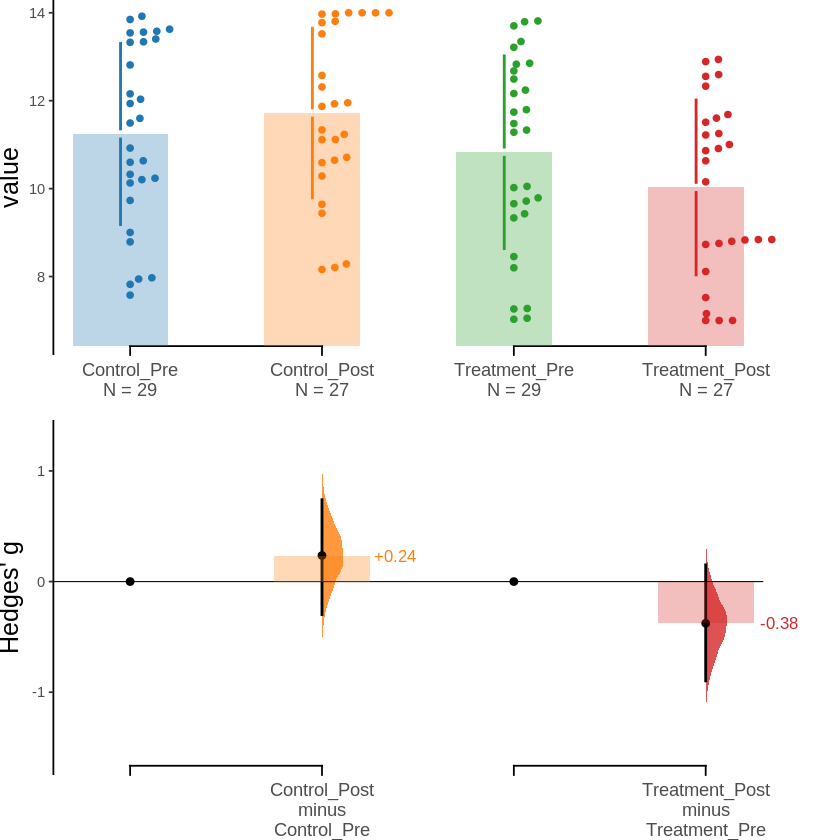

In [48]:
# build the delta-delta estimation plot with hegdes g
dabest_plot(two_group_two_condition.hedges_g)

### Cohen's d plot
Edit plot aesthetics at https://acclab.github.io/DABEST-python/tutorials/09-plot_aesthetics.html

In [49]:
# Generate the between groups cohens_d
two_group_two_condition.cohens_d <- cohens_d(two_group_two_condition)

# Examine the between groups cohens_d
two_group_two_condition.cohens_d

DABESTR v2025.3.14

Good afternoon!
The current time is 13:02 PM on Monday April 28, 2025.

The character(0) Cohen's d between Control_Post and Control_Pre is 0.239 [95%CI -0.302, 0.75].
The p-value of the two-sided permutation t-test is 0.3750, calculated for legacy purposes only.

The character(0) Cohen's d between Treatment_Post and Treatment_Pre is -0.382 [95%CI -0.91, 0.153].
The p-value of the two-sided permutation t-test is 0.1574, calculated for legacy purposes only.

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing the effect size (or greater),
assuming the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


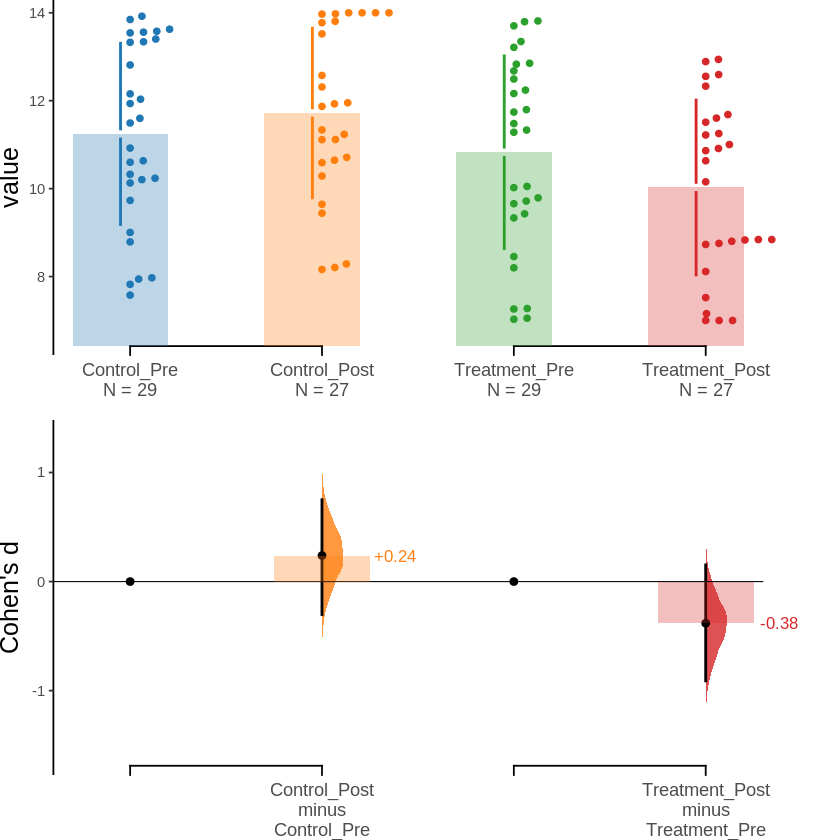

In [50]:
# build the delta-delta estimation plot with cohen's d
dabest_plot(two_group_two_condition.cohens_d)